# Computer Vision: Assignment 3 Part 2 - Object Detection [60%]
 
This notebook contains a partial minimal implementation (modelling, training and visualization code) an of a region-CNN object detector.
 
The first steps would be to understand what anchors are. Anchors are nothing but crops of a specific size and position in the image. The job of our object detector is to classify each anchor as containing an object or not. If the anchor contains an object, we want to find out by how much our anchor needs to change in shape and position to best fit the object in it. (By how much the height, width and center x and y cordinates change.)
 
Hence, object detection is a multi task network which does **classification** and **regression**.
 
 
The final objective of completing this notebook is to generate some visualizations of the network running on images in the validation set. 

You should upload the completed notebook to NYU Classes.

Let's start by loading some important modules

In [ ]:
# load important modules
!git clone https://github.com/simonkorman/CV-Ex3-part2.git
%cd CV-Ex3-part2

Cloning into 'CV-Ex3-part2'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 18), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.
/content/CV-Ex3-part2


## Dataset

Let's introduce our dataset. We have a Pytorch dataloader which outputs images and the ground truth data for the bounding boxes. We visualize the dataset below. You don't need to write any code here. However, you can try to get a good understanding of the structure of the dataset. 

In [ ]:
from extras.shapes_loader import get_shapes_loader
from extras.util import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
from extras.encoder import ResnetEncoder
import torch.nn.functional as F
from extras.anchors import get_offsets
from extras.boxes import box_iou, nms
import numpy as np

use_cuda = torch.cuda.is_available()

batch_sz =  4 # batch size for training and testing

# data loading: You may (*and should*) change the dataset sizes (make sure that they are multiples of the batch size)
trainloader, valloader, _ = get_shapes_loader(batch_sz=batch_sz, train_samples=1200, val_samples=600)

device = 'cuda' 

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)


A visual taste of the dataset, given as sample (image) / target (labels) pairs, which consists of triangle/square/circle colored objects on a uniform background.

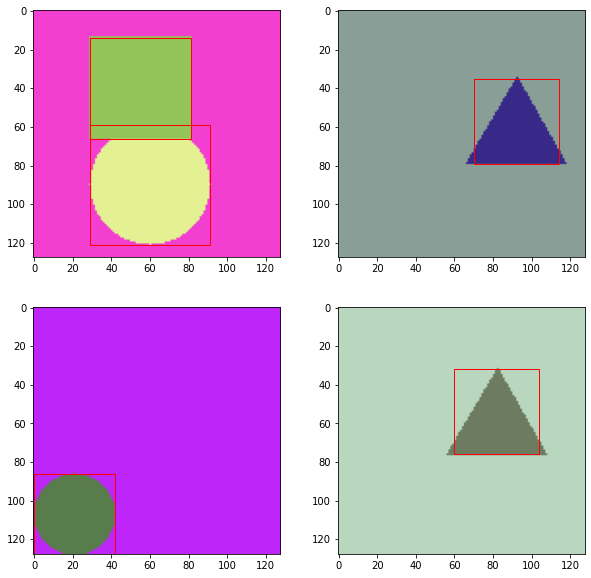

In [ ]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)
visDet(sample, target)

### Target Data for the Dataset

The targets of the dataset have 2 types of information for each image. 

1. The **bounding boxes** which is a tensor of size (N x 4).
here is N is the number of objects in the image and 4 correspond to:

    a. top left x coordinate
    b. top left y coordinate
    c. bottom right x coordinate
    d. bottom right y coordinate

2. The **classification labels** of size Nx1. Here the 1 corresponds to the label of the object (whether it is a triangle, square or circle). We will basically ignore the label in this excercise (i.e. treat all objects as one class).


In [ ]:
print(target[0])

{'bounding_box': tensor([[ 29,  59,  91, 121],
        [ 29,  14,  81,  66]]), 'labels': tensor([2, 1], dtype=torch.int32)}


### Creating a fixed collection of "chunks" or "anchors" for our image. 

Our image is 128 x 128 in size and we will use a stride of 16, with 3 anchor sizes at each position, of dimensions 40x40, 50x50 and 60x60. We should get 192 anchors (since 128/16 = 8 and 8x8x3 = 192).

Hence, our neural network should output a feature map of 8 x 8 in spatial dimensions. Each grid point in this feature map is an anchor position, with 3 candidate anchors.

Your first ***task*** [**10%**] is to write the code that creates these 192 anchors with respect to an image size of 128x128. Each anchor is represented by the top left and bottom right x,y coordinates of the anchors (in this order) with respect to the pixel coordinates of a 128x128 image. 

Hence, the output of the below function should be a numpy array of size [192,4]. Make sure to think about the correct order of collecting these 192 anchors. They should be in coordination with the output of the network that we will see next.


In [ ]:
def get_anchor_boxes():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a numpy array of size [192,4]
    """
    stride = 16 # The stride of the final feature map is 16 (the model compresses the image from 128 x 128 to 8 x 8)
    map_sz = 128 # this is the length of height/width of the image

    anchor_boxes = torch.zeros([192, 4])
    # anchor_boxes[i, 0] == top_left_x
    # anchor_boxes[i, 1] == top_left_y
    # anchor_boxes[i, 2] == bottom_right_x
    # anchor_boxes[i, 3] == bottom_right_y
    strides = np.arange(0, map_sz, stride)

    k = 0
    
    for i in zip(strides):
      for j in zip(strides):
        dim = 40
        while dim < 61:
          anchor_boxes[k, 0] = j[0]
          anchor_boxes[k, 1] = i[0]
          anchor_boxes[k, 2] = dim + j[0]
          anchor_boxes[k, 3] = dim + i[0]
          dim += 10
          k += 1
    return anchor_boxes

# retrieve the anchors
anchor_boxes = get_anchor_boxes()
assert anchor_boxes.shape == (192,4)


### Model

We will use the 3rd output feature from the resnet18 encoder, which represents a stride of 16. Given a 128x128 image, it will result in a map of size 8 x 8, with depth of 256. On this feature map we applay an additional standard 3x3 convolutional layer (+relu activation) that will leave us again with a 8x8x256 intermediate feature embedding. 

Recall that we wish to make predictions per anchor. We associate each of the 8x8 spatial dimensions with those of the respecive anchors. Therefore, for each spatial location we will add two output heads, which will predict the object existence and required bounding-box location update. These are implemented by operating on the entire volume at once, using 2 separate simple 1x1 convolutions with the respective output dimensions. 

Our model is defined by the class 'ShapesModel', where the 'forward' function defines the forward pass of the network.

### Illustration of the suggested architecture
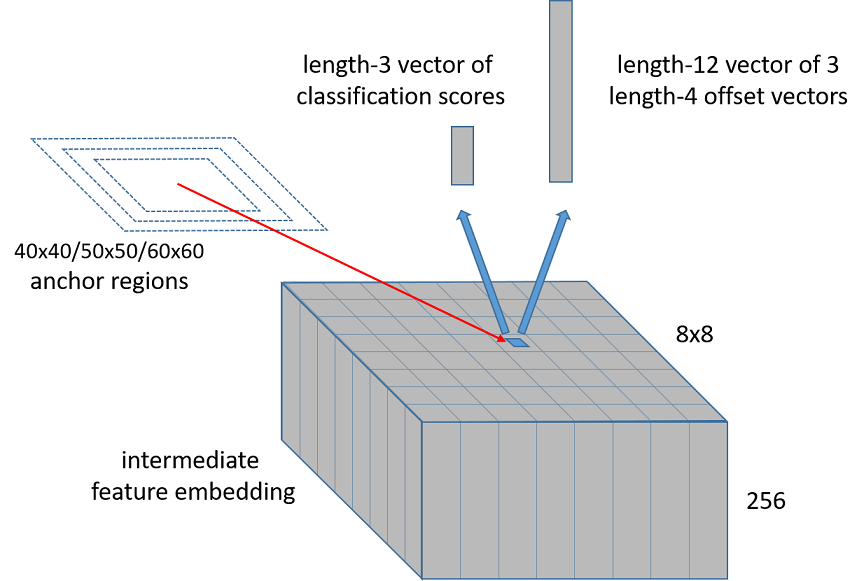

In [ ]:
class ShapesModel(nn.Module):

    def __init__(self):
        super(ShapesModel, self).__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 34 encoder
        self.encoder = ResnetEncoder(num_layers=34, pretrained=False)

        # a small conv net
        self.conv = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(256)

        # This is a head that predicts whether a chunk/anchor contains an object or not.
        self.cls_logits = nn.Conv2d(256, 3*1, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(3)

        # This is a head that regresses over the 4 bounding box offsets for each anchor
        self.bbox_pred = nn.Conv2d(256, 3*4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(12)

    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function
        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)
        return layer
    
    def reshape_regressions(self, cls_pred, box_pred):
        # helper function that gets outputs in the right shape for applying the loss
        # A = number of anchors (3)
        # C is 1
        N, AxC, H, W = cls_pred.shape
        Ax4 = box_pred.shape[1]
        A = Ax4 // 4
        C = AxC // A
        cls_pred = self.permute_and_flatten(cls_pred, N, A, C, H, W)
        
        box_pred = self.permute_and_flatten(box_pred, N, A, 4, H, W)
        return cls_pred, box_pred

    def forward(self, x):
        bt_sz = x.size(0)

        # we take the 3rd output feature map of size 8 x 8 from
        # the resnet18 encoder this means that the stride
        # is 16 as our input image is 128x128 in size.
        x = self.encoder(x)[3]

        # next pass it through a convolutional layer
        x = F.relu(self.conv(x))

        # finally make the predictions
        cls_pred = torch.sigmoid(self.cls_logits(x))
        box_pred = self.bbox_pred(x)
  
        # expected output sizes of head (dimension 0 is for the batch_size)
        assert cls_pred.shape[1:] == (3, 8, 8)
        assert box_pred.shape[1:] == (12, 8, 8)
        # this is a rearragenemt of the output tensors dimensions
        cls_pred, box_pred = self.reshape_regressions(cls_pred, box_pred)

         # expected output sizes of head (dimension 0 is for the batch_size)
        assert cls_pred.shape[1:] == (192, 1)
        assert box_pred.shape[1:] == (192, 4)
        
        return cls_pred.squeeze(2), box_pred


Basic testing of the model on a random input

In [ ]:
m = ShapesModel()
a = torch.randn(1,3,128,128) # dummy input
cls_pred, box_pred = m(a)
print('The outputs of the net are of size: ', cls_pred.size(), box_pred.size())

assert cls_pred.size() == (1,192) and box_pred.size() == (1,192,4)

The outputs of the net are of size:  torch.Size([1, 192]) torch.Size([1, 192, 4])


## **Supervision:** 1. organizing the ground-truth information

***get_GT_anchors*** is a function that converts the ground-truth information to the world of our anchors. Specifically, given the collection of true object bounding-boxes, it will assign to each of our anchors the following: 

1. Whether it has an object in it or not. This is done by measuring IOU (intersection-over-union) of the chunk with each of the true bounding boxes. If the (maximal found) IOU is > 0.7, we say that the chunk contains the object. If it is less than 0.3, we say the chunk only contains background. If the value is somewhere in between, we say it is a bad chunk (and will not use it's contribution to the loss function).

2. How much should the anchor change in height, width and how much should it translate to best fit the object. These offsets are 4 values, for the height, width, center x and y coordinate. 

Your second ***task*** [**10%**] is to calculate those values. Fill out the  '*get_anchor_labels_and_offsets*' helper function below.

In [ ]:
# You may use this helper function that computes the IoU of two boxes
def bb_intersection_over_union(boxA, boxB):

    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def permute_and_flatten(layer, N, A, C, H, W):
    # helper function that rearranges the input for the loss function
    layer = layer.view(N, -1, C, H, W)
    layer = layer.permute(0, 3, 4, 1, 2)
    layer = layer.reshape(N, -1, C)
    return layer

def reshape_regressions(cls_pred, box_pred):
    # helper function that gets outputs in the right shape for applying the loss
    # A = number of anchors (3)
    # C is 1
    N, AxC, H, W = cls_pred.shape
    Ax4 = box_pred.shape[1]
    A = Ax4 // 4
    C = AxC // A
    cls_pred = permute_and_flatten(cls_pred, N, A, C, H, W)
    
    box_pred = permute_and_flatten(box_pred, N, A, 4, H, W)
    return cls_pred, box_pred

def get_offsets1(gt_boxes, ex_boxes):
    """
    This function returns the offsets that need to applied to gt_boxes to morph them into ex_boxes.
    Both boxes should be of the same shape, N x 4.
    The output would be offsets given in a torch tensor of size N x 4.
    """
    ex_width = ex_boxes[2] - ex_boxes[0]
    ex_height = ex_boxes[3] - ex_boxes[1]
    ex_center_x = ex_boxes[0] + 0.5*ex_width
    ex_center_y = ex_boxes[1] + 0.5*ex_height

    gt_width = gt_boxes[2] - gt_boxes[0]
    gt_height = gt_boxes[3] - gt_boxes[1]
    gt_center_x = gt_boxes[0] + 0.5*gt_width
    gt_center_y = gt_boxes[1] + 0.5*gt_height


    delta_x = (gt_center_x - ex_center_x) / ex_width
    delta_y = (gt_center_y - ex_center_y) / ex_height
    delta_scaleX = torch.log(gt_width / ex_width)
    delta_scaleY = torch.log(gt_height / ex_height)

    offsets = torch.cat([delta_x.unsqueeze(0), 
                    delta_y.unsqueeze(0),
                    delta_scaleX.unsqueeze(0),
                    delta_scaleY.unsqueeze(0)],
                dim=0)
    return offsets

# This is the function you should complete      
def get_anchor_labels_and_offsets(true_boxes, anchor_boxes, sz=128):
    '''    
    INPUT:
    true_boxes: [Nx4]: actual bounding boxes in the image. Here N is the number of bounding boxes the image has.
    anchor_boxes: [192 x 4]: Anchor boxes of an image of size 128 x 128 with stride 16. 
    sz : 128
    OUTPUT: 
    anchor_classes: [192 x 1] : Class labels for each anchor: 1 is for foreground, 0 is for background and -1 is 
                            for a bad anchor [where IOU is between 0.3 and 0.7].
    anchor_offsets: [192 x 4]: Offsets for anchor to best fit the bounding box object. Assign 0 values for 0 and -1 class anchors.
    '''
    high_threshold = 0.7
    low_threshold = 0.3

    n_BBs = true_boxes.shape[0]
    n_anchors = anchor_boxes.shape[0]
    anchor_classes = torch.zeros((n_anchors,1))
    anchor_offsets = torch.zeros((n_anchors,4))
    
    for i in range(n_anchors):
      max = (0, 0)
      for j in range(n_BBs):
        iou = bb_intersection_over_union(anchor_boxes[i].cuda(), true_boxes[j])
        if iou > max[0]:
          max = (iou, j)
      # if iou is higher than the high threshold we'll class it as 1 (foreground)
      # else it will be 0 or -1 but maybe in other bounding boxes there will be an object
      # so we break only if we get a 1
      if max[0] > high_threshold:
        anchor_classes[i] = 1
        anchor_offsets[i] = get_offsets1(anchor_boxes[i], true_boxes[max[1]])
      elif max[0] < low_threshold:
        anchor_classes[i] = 0
      else:
        anchor_classes[i] = -1
    return anchor_classes, anchor_offsets


#  The main function - no need to modify
def get_GT_anchors(target, sample, anchor_boxes):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''
    batched_preds = []
    batched_offsets = []
    final_anchor_labels = []
    final_anchor_offsets = []
    iter = 0
    for t, s in zip(target, sample):
        bboxes = t['bounding_box'].to(device).float()     
        anchor_labels, anchor_offsets = get_anchor_labels_and_offsets(bboxes, anchor_boxes, sz=128)

        final_anchor_labels.append(anchor_labels)
        final_anchor_offsets.append(anchor_offsets)

    final_anchor_labels = torch.squeeze(torch.stack(final_anchor_labels, dim=0))
    final_anchor_offsets = torch.stack(final_anchor_offsets, dim=0)
    return final_anchor_labels, final_anchor_offsets    

### Test code (for get_GT_anchors) that you might want to use

In [ ]:
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

#assert len(anchor_offsets) == batch_sz
assert sample.shape == (batch_sz,3,128,128)
assert anchor_boxes.shape == (192,4)

anchor_labels, anchor_offsets = get_GT_anchors(target, sample, anchor_boxes)

assert anchor_labels.shape == (batch_sz,192)
assert anchor_offsets.shape == (batch_sz,192,4)


# **Supervision:** 2. defining loss functions

We need to define loss functions which will compare the ground-truth-extracted data with the predictions of the network. We use a combination of two losses:

1. **Classification Loss** - The classification loss should be applied to all positive (containing an object) and negative anchors (does not contain an object). The loss should not be calculated for the anchors whose IOU values are between 0.7 and 0.3. Apply a binary-cross-entropy-loss (e.g. torch.nn.BCELoss) between the objecteness score and the network classification.
2. **Bounding-Box Update Loss** - The BB loss should be applied to all positive (containing an object) anchors. The loss should not be calculated for the anchors whose IOU values are below 0.7. Apply a Smooth L1 loss (e.g. torch.nn.SmoothL1Loss) to regress on the bounding box offsets.

Note that in this setup the ratio between sampled background and foreground anchors might be biased towards over-sampling background anchors. This could be handled (**this is optional**) by implementing hard online negative sampling, which means to correct this bias.

Your third ***task*** [**10%**] is to write the code for the '*class_loss*' and '*bbox_loss*' loss functions. 


In [ ]:
def class_loss(pred_class, anchor_labels, device="cuda"):
  total_loss = torch.zeros(1).cuda()
  for i in range(anchor_labels.shape[0]):
    for j in range(anchor_labels.shape[1]):
      if anchor_labels[i][j] != -1:
        BCELoss = torch.nn.BCELoss()
        curr_loss = BCELoss(pred_class[i][j], anchor_labels[i][j])
        total_loss += curr_loss
  return total_loss

def bbox_loss(out_bbox, anchor_offsets, anchor_labels):
  total_loss = torch.zeros(1).cuda()
  for i in range(anchor_labels.shape[0]):
    for j in range(anchor_labels.shape[1]):
      if anchor_labels[i][j] == 1:
        smooth = torch.nn.SmoothL1Loss()
        curr_loss = smooth(out_bbox[i][j].cuda(), anchor_offsets[i][j].cuda())
        total_loss += curr_loss
  return total_loss



## Training Function. 

This is the training function. You do not need to change any code here, though you might want to add some debugging signals. 

In [ ]:
def train(ep, model, trainloader, optimizer):
        total_loss = 0
        b_loss = 0
        c_loss = 0
        debug_freq = 10
        validation_freq = 50
        window_loss = np.zeros(3)
        for i, (sample, targets) in enumerate(trainloader):

            ims = torch.stack(list(sample), dim=0).to(device)
            model.train() # switch to train mode

            anchor_labels, anchor_offsets = get_GT_anchors(targets, ims, anchor_boxes)
            pred_class, pred_bb = model(ims)      

            # print(anchor_offsets[0])
            # print(anchor_labels[0])
            loss_bbox = bbox_loss(pred_bb, anchor_offsets, anchor_labels)
            # print(loss_bbox)
            print('loss_bbox:',loss_bbox, 'loss_bbox.item()', loss_bbox.item(), 'type:', type(loss_bbox), 'shape:', loss_bbox.shape)    
            # print('min:',anchor_labels.min().min(),'max:',anchor_labels.max().max())
            loss_cls = class_loss(pred_class, anchor_labels.cuda())
            print('loss_cls:',loss_cls.item(), 'type:', type(loss_cls), 'shape:', loss_cls.shape)                    
            
            loss = loss_cls + loss_bbox 
            #print('>>>> cls loss shape', loss_cls.shape, 'box loss shape', loss_bbox.shape, )            

            # gradient step
            if loss.item() != 0:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


            # validation (once in a while)
            if i%validation_freq==(validation_freq-1):
                print('>> iteration',i+1,'out of',len(trainloader), ': VALIDATING on', len(valloader), 'batches...')
                model.eval() # switch to eval mode

                val_losses = np.zeros(len(valloader))
                for j, (sample, targets) in enumerate(valloader):
                    ims = torch.stack(list(sample), dim=0).to(device)

                    anchor_labels, anchor_offsets = get_GT_anchors(targets, ims, anchor_boxes)
                    pred_class, pred_bb = model(ims)               
                      
                    loss_bbox = bbox_loss(pred_bb, anchor_offsets, anchor_labels)
                    loss_cls = class_loss(pred_class, anchor_labels.cuda())
                    val_losses[j] = loss_cls + loss_bbox 
              
                # print('>> iteration',i+1,'out of',len(trainloader), ': VALIDATION loss:', val_losses.mean())

            # debugging
            total_loss += loss.item()
            window_loss = window_loss + np.array([loss_bbox.item(), loss_cls.item(), loss.item()])/debug_freq

            if i%debug_freq==(debug_freq-1):
              # print('>> iteration',i+1,'out of',len(trainloader), ': loss ', window_loss[2], '(closs', window_loss[0], 'bloss', window_loss[1], ')')
              window_loss = np.zeros(3)
        #print(total_loss)    
        avg_loss = float(total_loss / len(trainloader))
        print('Trained Epoch: {} | Avg Train Loss over epoch: {}'.format(ep, avg_loss))

# **Training** - model optimization and storing
This cell contains the entire training (optimization) of your model. At the end, the resulting model is saved as a '.pt', which you are required to submit along with this main 'ipynb' file.

## **IMPORTANT NOTICE**:  When we run your submission we will run all of the notebook cells **except** this cell (further down there is a cell that loads the saved model)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
n_epochs = 24
model = ShapesModel().to(device)

learning_rate = 1
exp = 0
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9, weight_decay=1e-4)    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate*0.01)

# optimize

# Assuming optimizer has two groups.
lambda_group1 = lambda epoch: learning_rate / (2 ** exp)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda_group1])


for ep in range(n_epochs):
    print('==================================== epoch', ep, '=====================================')
    train(ep, model, trainloader, optimizer)
    if (ep % 6 == 0 and ep != 0):
      exp += 1
      scheduler.step()
    



# Specify a path
PATH = "entire_model.pt"

# Save
torch.save(model, PATH)

Streaming output truncated to the last 5000 lines.
loss_cls: 1.4671683311462402 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_bbox: tensor([0.0197], device='cuda:0', grad_fn=<AddBackward0>) loss_bbox.item() 0.01966499723494053 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_cls: 0.009067052975296974 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_bbox: tensor([0.0408], device='cuda:0', grad_fn=<AddBackward0>) loss_bbox.item() 0.04081204533576965 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_cls: 0.023586174473166466 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_bbox: tensor([0.0163], device='cuda:0', grad_fn=<AddBackward0>) loss_bbox.item() 0.016321204602718353 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_cls: 0.45663172006607056 type: <class 'torch.Tensor'> shape: torch.Size([1])
loss_bbox: tensor([0.0162], device='cuda:0', grad_fn=<AddBackward0>) loss_bbox.item() 0.01615174300968647 type: <class 'torch.Tensor'> shape: tor

# Model Predictions - (including post-processing)

At this point, you may apply your model on input images and get output results (in the form of a score and a shift BB for each of the anchors). This result would require some post-processing, in order to come up with a presentable and measurable result.

The '*predict*' function is designed to output max_BBs = 5 leading bounding boxes. In order to do so, it relies on the anchor scores of your output and applies non-maximal-suppression (NMS) as a main way to clear up the output. 

NMS is required since many of the anchors near an actual object will fire, resulting in a lot of boxes. NMS handles these multiple predictions by 'choosing' a single box for a predicted object instead of multiple ones. This is best signified through another image:

![NMS](https://miro.medium.com/max/1000/0*WI5_K3bAbYaRyzE-.png)


In [ ]:
# apply model and post-processing
def predict(model, sample, max_BBs=5):

    # Apply model:
    ims = torch.stack(list(sample), dim=0).to(device)
    pred_class, pred_bb = model(ims)    

    # Post processing:
    iou_threshold = 0.1 # you may manipulate this. 

    target = [{} for i in range(batch_sz)]

    boxes = torch.zeros([192,4]).cuda()
    for ind in range(batch_sz):
        for t in range(192):
            try:
              boxes[t] =  torch.tensor(anchor_boxes[t]).cuda() + pred_bb[ind,t]
              scores = pred_class[ind].squeeze()
              nms_indices = nms(boxes, scores, iou_threshold) # NMS
            except:
              pass
        if len(nms_indices) > max_BBs:
            nms_indices = nms_indices[:max_BBs]
        # print(target[ind]['bounding_box'])
        # print(nms_indices)
        # print(boxes[nms_indices])
        target[ind]['bounding_box'] = boxes[nms_indices]

    return target


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


accuracies: [1.         1.         1.         0.66666669]
mean accuracy: 0.9166666716337204


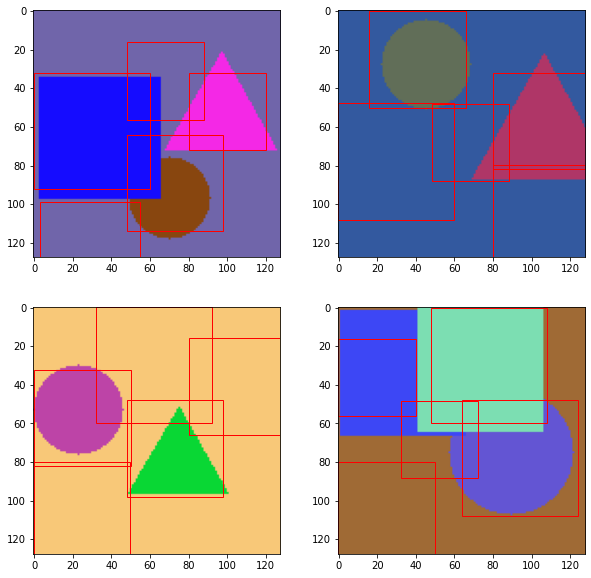

In [ ]:
# Testing the 'predict' function on a train or validation batch

# taking a batch (you may change trainloader to valloader)
sample, target = iter(trainloader).next()
sample = torch.stack(sample,dim=0)

max_BBs = 5 # do not modify this

# predict
result = predict(model, sample, max_BBs=max_BBs)

# batch accuracies function - Do not modify!
def get_batch_accuracies(result, target, max_BBs=5):
    accuracies = np.zeros(batch_sz)
    for i in range(batch_sz):
        res_BBs = result[i]['bounding_box'].cpu()
        if res_BBs.shape[0] > max_BBs:
            res_BBs = res_BBs[:max_BBs]
        res = box_iou(res_BBs,target[i]['bounding_box'])
        best_preds = res.max(0).values
        accuracies[i] = ((best_preds>0.5).count_nonzero()/len(best_preds))
    return accuracies

# check accuracy:
accuracies = get_batch_accuracies(result,target)
print('accuracies:', accuracies)
print('mean accuracy:', accuracies.mean())

# visualize:
visDet(sample, result)


# Load model and evaluate on the test set

Your fourth and last ***task*** [**30%**] is to tune your network in order to get better accuracy. You may play with the data (e.g. amounts of), model, it's training (e.g. hyper parameters), post-processing, etc'.

Please describe here shortly what you did in order to get your best results:

* **Increased the** **number of layers**  of the model from 18 layers to 34. As we put more layers into the ResNet architucture, there are more parameters for computation, which increase the accuracy significantly

* **Increased the sizes of the train dataset and validation dataset**. We've done so because the more samples the network is familiar with, the more trained and accurate the network is. The bigger training set size means that the model's parameters are more accurate, and the bigger validation set size means that the hyper-parameters are more accurate.

* **Increased the number of epochs to 24**. The more epochs, the network is more trained. 

* Implemented **step decay** for a dynamic learning rate. We declared that the training process will due to 24 epochs, with initial learning rate of 0.1. We defined that every 6 epochs the learning rate will be halved. We've done it because we noticed that after 6 epochs the training of the network is locally converging. It means that the optimizer knows where is the local minimum direction from the SGD, but the learning rate is too high and the optimizer can't reach there, hence the loss value remains the same. So we decrease the learning rate to help the network to get the local minimum, so it will have minimum loss.




In [ ]:
# Load
if True:
    model = torch.load(PATH)
    model.eval()


### accuracy functions - do not modify

In [ ]:
# batch accuracies function - Do not modify!
def get_batch_accuracies(result, target, max_BBs=5):
    accuracies = np.zeros(batch_sz)
    for i in range(batch_sz):
      try:
        res_BBs = result[i]['bounding_box'].cpu()
        if res_BBs.shape[0] > max_BBs:
            res_BBs = res_BBs[:max_BBs]
        res = box_iou(res_BBs,target[i]['bounding_box'])
        best_preds = res.max(0).values
        accuracies[i] = ((best_preds>0.5).count_nonzero()/len(best_preds))
      except:
        pass
    return accuracies

# accuracies function - Do not modify!
def evaluate_accuracy(loader):
    accuracy = 0
    for j, (sample, target) in enumerate(loader):
          sample = torch.stack(list(sample), dim=0).to(device)
          result = predict(model, sample)
          batch_accuracies = get_batch_accuracies(result,target)
          accuracy += batch_accuracies.mean()
    result = accuracy/(j+1)
    # print('mean accuracy:', result)
    return result

## accuracy evaluations (test set is the important one..)

In [ ]:
_, _, testloader = get_shapes_loader(batch_sz=batch_sz, test_samples=500)

train_acc = evaluate_accuracy(trainloader)
val_acc = evaluate_accuracy(valloader)
test_acc = evaluate_accuracy(testloader)
print('train acc:',train_acc)
print('val acc:',val_acc)
print('test acc:',test_acc)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train acc: 0.8740277801454067
val acc: 0.8806944468617439
test acc: 0.886833335518837
